## Self supervised learning - fine-tuning CLIP

### Notebook goal

We will be fine-tuning an image encoder model that indexes images using CLIP, as well as a text encoder model that encodes our product titles. With these models, we can locate an image by finding the nearest image vector to our text vector. To accomplish this, we will fine-tune the CLIP model, which was trained on a large dataset and has demonstrated impressive zero-shot performance. Our approach will be to use a pre-trained model as a baseline, and attempt to improve its performance on our task through fine-tuning. To accomplish this, we will use Polyvore dataset, which contains images of ecommerce products along with metadata such as the title, category and description.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dnepozitek/polyvore-outfits")

print("Path to dataset files:", path)

In [1]:
import gc
import os
import textwrap

import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
# from tabulate import tabulate

from sklearn.model_selection import train_test_split

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import tensorflow as tf

In [ ]:
# install TF similarity
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim
import tensorflow_similarity.losses as tfsim_losses

In [4]:
# Install Transformer deps from hugging face
try:
    from transformers import TFCLIPTextModel, TFCLIPVisionModel, CLIPTokenizer, TFCLIPModel
except ModuleNotFoundError:
    !pip install transformers
    from transformers import TFCLIPTextModel, TFCLIPVisionModel, CLIPTokenizer, TFCLIPModel

In [5]:
tfsim.utils.tf_cap_memory()
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

In [6]:
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.17.1
TensorFlow Similarity 0.17.1


In [7]:
N_CPU = os.cpu_count()
IMG_SIZE = 224
BATCH_SIZE = 64
COLOR_CHANNELS = 3
N_TOKENS = 77
DATA_DIR = "multi_modal_datasets"

## Data preparation

In [8]:
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dnepozitek/polyvore-outfits")

print("Path to dataset files:", path)

100%|██████████| 6.21G/6.21G [04:25<00:00, 25.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dnepozitek/polyvore-outfits/versions/1


In [10]:
!mv /root/.cache/kagglehub/datasets/dnepozitek/polyvore-outfits/versions/1/polyvore_outfits .

In [11]:
# %cd

In [13]:
import os
import json

polyvore_dir = 'polyvore_outfits'

filename = os.path.join(polyvore_dir, 'polyvore_item_metadata.json')
with open(filename,'r') as fl:
    data = json.load(fl)

df = pd.DataFrame(data).T

df['id'] = df.index
df['path'] = df['id'].apply(lambda x: os.path.join(polyvore_dir, 'images', x + '.jpg'))
df['label'] = df['category_id']
df['title'] = df['title']

df[['id', 'path', 'label','title']].to_csv(os.path.join(polyvore_dir, 'polyvore_item_metadata.csv'),index=False)
df.head()

,url_name,description,catgeories,title,related,category_id,semantic_category,id,path,label
211990161,neck print chiffon plus size,,,,,15,tops,211990161,polyvore_outfits/images/211990161.jpg,15
183179503,christian pellizzari floral jacquard trousers,Gold and black silk blend floral jacquard trou...,"[Women's Fashion, Clothing, Pants, Christian P...",Christian Pellizzari floral jacquard trousers,"[Floral pants, Grey pants, Print pants, Patter...",28,bottoms,183179503,polyvore_outfits/images/183179503.jpg,28
152771755,natures jewelry stainless steel not,,,,,65,jewellery,152771755,polyvore_outfits/images/152771755.jpg,65
190445143,balmain women high waist flared,Decorative gold colored buttons with lion deta...,"[Women's Fashion, Clothing, Pants, Balmain pants]",Balmain Women High Waist Flared Knit Pants,"[Balmain, Flared pants, High-waisted pants, Kn...",28,bottoms,190445143,polyvore_outfits/images/190445143.jpg,28
211444470,acler orson high waist belted,This Acler Orson High Waist Belted Short featu...,"[Women's Fashion, Clothing, Shorts, Marissa We...",Acler Orson High Waist Belted Short,"[Short shorts, High-waisted shorts, High rise ...",29,bottoms,211444470,polyvore_outfits/images/211444470.jpg,29


In [14]:
# Get the set of unique image ids in the unzipped dir
image_ids = set(df.path)

print(f"There are {len(image_ids)} unique image ids")

There are 251008 unique image ids


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251008 entries, 211990161 to 181567392
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   url_name           251008 non-null  object
 1   description        251008 non-null  object
 2   catgeories         251008 non-null  object
 3   title              251008 non-null  object
 4   related            251008 non-null  object
 5   category_id        251008 non-null  object
 6   semantic_category  251008 non-null  object
 7   id                 251008 non-null  object
 8   path               251008 non-null  object
 9   label              251008 non-null  object
dtypes: object(10)
memory usage: 29.1+ MB


In [18]:
text_list = df["title"].to_list()
imgs_list = df["path"].to_list()

In [19]:
train_images, val_images, train_texts, val_texts = train_test_split(
    imgs_list, text_list, test_size=0.2, random_state=17
)

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

train_tokens = tokenizer(
    train_texts,
    padding="max_length",
    return_tensors="tf",
    truncation=True,
)

val_tokens = tokenizer(
    val_texts,
    padding="max_length",
    return_tensors="tf",
    truncation=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

In [20]:
def get_img_emb(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE], method="nearest")
    image = tf.transpose(image, [2, 0, 1])  # Channels first
    return image


def data_mapper(img, input_ids, attention_mask):
    return get_img_emb(img), tf.squeeze(input_ids), tf.squeeze(attention_mask)

In [21]:
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_images, train_tokens["input_ids"], train_tokens["attention_mask"]))
    .map(data_mapper, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(2000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("Train Dataset Shapes")
for i in train_ds.take(1):
    for nm, tensor in zip(["Image", "Input Id", "Attention Mask"], i):
        print(f"{nm}: {tensor.shape}")

val_ds = (
    tf.data.Dataset.from_tensor_slices((val_images, val_tokens["input_ids"], val_tokens["attention_mask"]))
    .map(data_mapper, num_parallel_calls=N_CPU)
    .cache()
    .batch(BATCH_SIZE)
)

print("\n")
print("Val Dataset Shapes")
for i in val_ds.take(1):
    for nm, tensor in zip(["Image", "Input Id", "Attention Mask"], i):
        print(f"{nm}: {tensor.shape}")

Train Dataset Shapes
Image: (64, 3, 224, 224)
Input Id: (64, 77)
Attention Mask: (64, 77)


Val Dataset Shapes
Image: (64, 3, 224, 224)
Input Id: (64, 77)
Attention Mask: (64, 77)


## Model Setup

### Loading CLIP Weights

Our goal is to obtain embeddings of images and texts that enable us to accurately measure the similarity between an image and its corresponding title. To achieve this, we must first obtain the image and text embeddings. We can do this by obtaining the projection layer weights of the vision and text encoder models of CLIP, which will provide us with a solid foundation for measuring the distance between images and their associated titles.

In [22]:
model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
vision_weights = tf.Variable(model.weights[-2])
text_weights = tf.Variable(model.weights[-1])

del model
# Clear the Keras backend now that we deleted the original model.
tf.keras.backend.clear_session()

tf_model.h5:   0%|          | 0.00/606M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


### Load Pretrained CLIPTextModel

In [23]:
CLIP_text_model = TFCLIPTextModel.from_pretrained(
    "openai/clip-vit-base-patch32",
);

Some layers from the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing TFCLIPTextModel: ['clip/vision_model/encoder/layers_._9/self_attn/out_proj/kernel:0', 'clip/logit_scale:0', 'clip/vision_model/encoder/layers_._11/self_attn/v_proj/kernel:0', 'clip/vision_model/encoder/layers_._6/layer_norm2/beta:0', 'clip/vision_model/encoder/layers_._0/mlp/fc1/bias:0', 'clip/vision_model/encoder/layers_._7/self_attn/k_proj/kernel:0', 'clip/vision_model/encoder/layers_._7/layer_norm1/gamma:0', 'clip/vision_model/encoder/layers_._7/mlp/fc2/kernel:0', 'clip/vision_model/encoder/layers_._9/layer_norm2/gamma:0', 'clip/vision_model/encoder/layers_._5/self_attn/k_proj/kernel:0', 'clip/vision_model/encoder/layers_._8/self_attn/q_proj/bias:0', 'clip/vision_model/encoder/layers_._5/self_attn/q_proj/bias:0', 'clip/vision_model/embeddings/class_embedding:0', 'clip/vision_model/encoder/layers_._4/layer_norm1/gamma:0', 'clip/vision_model/encoder/layers_._8/mlp/fc2/kernel:0', 'clip

### Load Pretrained CLIPVisionModel

In [24]:
CLIP_vision_model = TFCLIPVisionModel.from_pretrained(
    "openai/clip-vit-base-patch32",
);

Some layers from the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing TFCLIPVisionModel: ['clip/text_model/encoder/layers_._6/mlp/fc1/kernel:0', 'clip/logit_scale:0', 'clip/text_model/encoder/layers_._0/self_attn/out_proj/kernel:0', 'clip/text_model/encoder/layers_._7/self_attn/q_proj/bias:0', 'clip/text_model/encoder/layers_._0/mlp/fc1/bias:0', 'clip/text_model/encoder/layers_._7/mlp/fc2/bias:0', 'clip/text_model/encoder/layers_._2/self_attn/k_proj/bias:0', 'clip/text_model/encoder/layers_._5/mlp/fc2/kernel:0', 'clip/text_model/encoder/layers_._5/self_attn/q_proj/kernel:0', 'clip/text_model/encoder/layers_._9/self_attn/q_proj/bias:0', 'clip/text_model/encoder/layers_._7/layer_norm2/gamma:0', 'clip/text_model/encoder/layers_._4/mlp/fc2/bias:0', 'clip/text_model/encoder/layers_._9/self_attn/out_proj/kernel:0', 'clip/text_model/encoder/layers_._8/mlp/fc1/bias:0', 'clip/text_model/encoder/layers_._5/layer_norm2/beta:0', 'clip/text_model/encoder/layers_._9/s

In [25]:
# NOTE: If you have GPU restrictions you can set the base models as non-trainable
# and only train the projector layer for a faster optimization.
CLIP_vision_model.trainable = True
# CLIP_text_model.trainable = False

CLIP_vision_model.summary()
print("\n")
CLIP_text_model.summary()

Model: "tfclip_vision_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 clip (TFCLIPVisionMainLaye  multiple                  87456000  
 r)                                                              
                                                                 
Total params: 87456000 (333.62 MB)
Trainable params: 87456000 (333.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model: "tfclip_text_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 clip (TFCLIPTextMainLayer)  multiple                  63165952  
                                                                 
Total params: 63165952 (240.96 MB)
Trainable params: 63165952 (240.96 MB)
Non-trainable params: 0 (0.00 Byte)
______________________________________________________________

## Joint Embedding Projections

Because the embedding sizes of CLIPVisionModel and CLIPTextModel are different, we'll need to add projection layers to the top of both models to ensure that their embeddings are of the same dimension. This step is essential for successful integration of the models, as the models require embeddings to be of the same dimension to be processed together. The projection layers help to transform the embeddings from one dimension to another, allowing for both the text and the images to be jointly embedded in the same space.

In [31]:
# def get_image_model(n_dims=512):
#     x = inputs = tf.keras.layers.Input((COLOR_CHANNELS, IMG_SIZE, IMG_SIZE), name="image")
#     x = CLIP_vision_model(x).pooler_output  # pooled CLS states
#     kernel_weights = tf.constant_initializer(vision_weights.numpy())
#     # Projection layer
#     embed = tf.keras.layers.Dense(n_dims, name="image_embedding", kernel_initializer=kernel_weights)(x)

#     model = tf.keras.models.Model(inputs=inputs, outputs=embed, name="image_model")
#     return model



def get_image_model(n_dims=512):
    class CLIPVisionLayer(tf.keras.layers.Layer):
        def __init__(self, clip_vision_model):
            super(CLIPVisionLayer, self).__init__()
            self.clip_vision_model = clip_vision_model

        def call(self, inputs):
            # Call CLIP_vision_model within the call method
            return self.clip_vision_model(inputs).pooler_output

    x = inputs = tf.keras.layers.Input((COLOR_CHANNELS, IMG_SIZE, IMG_SIZE), name="image")
    # Create an instance of the custom layer
    clip_vision_layer = CLIPVisionLayer(CLIP_vision_model)
    # Pass the input tensor to the custom layer
    x = clip_vision_layer(x)
    kernel_weights = tf.constant_initializer(vision_weights.numpy())
    # Projection layer
    embed = tf.keras.layers.Dense(n_dims, name="image_embedding", kernel_initializer=kernel_weights)(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=embed, name="image_model")
    return model

In [43]:
# def get_text_model(n_dims=512):
#     inputs1 = tf.keras.layers.Input((N_TOKENS), dtype=tf.int32, name="input_ids")
#     inputs2 = tf.keras.layers.Input((N_TOKENS), dtype=tf.int32, name="attention_mask")
#     x = CLIP_text_model(input_ids=inputs1, attention_mask=inputs2).pooler_output  # pooled CLS states
#     kernel_weights = tf.constant_initializer(text_weights.numpy())
#     # Projection layer
#     embed = tf.keras.layers.Dense(n_dims, name="text_embedding", kernel_initializer=kernel_weights)(x)

#     model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=embed, name="text_model")
#     return model


def get_text_model(n_dims=512):
    class CLIPTextLayer(tf.keras.layers.Layer):
        def __init__(self, clip_text_model):
            super(CLIPTextLayer, self).__init__()
            self.clip_text_model = clip_text_model

        def call(self, inputs):
            input_ids, attention_mask = inputs
            # Call CLIP_text_model within the call method
            return self.clip_text_model(input_ids=input_ids, attention_mask=attention_mask).pooler_output

    # Define inputs as Keras Input layers
    input_ids = tf.keras.Input((N_TOKENS,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input((N_TOKENS,), dtype=tf.int32, name="attention_mask")

    # Create an instance of the custom layer
    clip_text_layer = CLIPTextLayer(CLIP_text_model)

    # Pass the input tensors to the custom layer
    x = clip_text_layer([input_ids, attention_mask])

    kernel_weights = tf.constant_initializer(text_weights.numpy())
    embed = tf.keras.layers.Dense(n_dims, name="text_embedding", kernel_initializer=kernel_weights)(x)

    model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=embed, name="text_model")
    return model

In [44]:
# img_model = get_image_model()
text_model = get_text_model()

img_model.summary()
print("\n")
text_model.summary()

Model: "image_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ clip_vision_layer (CLIPVisionLayer)  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ image_embedding (Dense)              │ (None, 512)                 │         393,728 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 393,728 (1.50 MB)

 Trainable params: 393,728 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

Model: "text_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 77)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 77)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ clip_text_layer           │ (None, 512)            │              0 │ input_ids[0][0],       │
│ (CLIPTextLayer)           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_embedding (Dense)    │ (None, 512)            │        262,656 │ clip_text_layer[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 262,656 (1.00 MB)

 Trainable params: 262,656 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

### Losses and Metrics

We have a dataset which have pairs of image and text. We only have positive examples here and in such a case multiple negatives ranking loss is a suitable choice. This considers every other pair other than ($x_i$, $y_i$) as negative pairs.

In [46]:
# loss_fn = tfsim_losses.MultiNegativesRankLoss()
loss_fn = tfsim_losses.MultiNegativesRankLoss(reduction="sum_over_batch_size")

Let's measure the baseline performance.

In [47]:
val_loss = 0
base_image_embeddings = []
base_text_embeddings = []
for image_batch, input_ids_batch, attention_mask_batch in tqdm(val_ds):
    image_embedding = img_model(image_batch, training=False)
    text_embedding = text_model([input_ids_batch, attention_mask_batch], training=False)

    image_embedding = tf.math.l2_normalize(image_embedding, axis=1)
    text_embedding = tf.math.l2_normalize(text_embedding, axis=1)

    base_image_embeddings.append(image_embedding.numpy())
    base_text_embeddings.append(text_embedding.numpy())

    # Compute the loss value for this minibatch.
    loss_value = loss_fn(text_embedding, image_embedding)
    val_loss += float(loss_value)

print(f"Mean Validation Loss: {val_loss / len(val_ds)}")
base_image_embeddings = np.concatenate(base_image_embeddings)
base_text_embeddings = np.concatenate(base_text_embeddings)

  1%|          | 4/785 [01:50<6:01:03, 27.74s/it]


KeyboardInterrupt: 

We'll use R@k metric for evaluation. This is a common metric used in evaluation of ranking. It is the average of recall by taking top k predictions.

In [ ]:
def recall_at_k(sim_matrix, k=1):
    """
    It is the mean of ratio of correctly retrieved documents
    to the number of relevant documents.
    This implementation is specific to
    data having unique label for each key
    """

    sorted_mat = np.argsort(sim_matrix, axis=1)[:, -k:]

    # Each key has unique label
    true_labels = np.arange(sorted_mat.shape[0]).reshape(-1, 1)
    true_labels = np.repeat(true_labels, k, axis=1)
    sorted_mat = sorted_mat - true_labels
    # the position in row corresponding to true positive
    # will be zero
    tps = np.any(sorted_mat == 0, axis=1)
    return tps.mean()

In [ ]:
base_sim_mat = np.matmul(base_text_embeddings, base_image_embeddings.T)
for k in range(1, 6):
    print("R@{}: {}".format(k, recall_at_k(base_sim_mat, k)))

R@1: 0.1361031518624642
R@2: 0.18958930276981853
R@3: 0.22015281757402103
R@4: 0.24880611270296085
R@5: 0.27650429799426934


## Training

we need to use a custom training loop that can handle the training of two models simultaneously. Example [this guide](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch#end-to-end_example_a_gan_training_loop_from_scratch), which shows how to create a custom training loop


In [ ]:
epochs = 5
img_optimizer = tf.keras.optimizers.Adam(1e-5)
text_optimizer = tf.keras.optimizers.Adam(1e-5)
train_step_losses = []
train_epoch_losses = []

@tf.function
def train_step(image_batch, text_batch):
    with tf.GradientTape() as img_tape, tf.GradientTape() as text_tape:
        image_embedding = img_model(image_batch, training=True)
        text_embedding = text_model(text_batch, training=True)

        image_embedding = tf.math.l2_normalize(image_embedding, axis=1)
        text_embedding = tf.math.l2_normalize(text_embedding, axis=1)

        # Compute the loss value for this minibatch.
        loss_value = loss_fn(text_embedding, image_embedding)

    img_grads = img_tape.gradient(loss_value, img_model.trainable_weights)
    text_grads = text_tape.gradient(loss_value, text_model.trainable_weights)

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    img_optimizer.apply_gradients(zip(img_grads, img_model.trainable_weights))
    text_optimizer.apply_gradients(zip(text_grads, text_model.trainable_weights))

    return loss_value

In [ ]:
# Custom Training Loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}")
    epoch_loss = 0

    # Iterate over the batches of the dataset.
    for step, (image_batch, input_ids_batch, attention_mask_batch) in enumerate(train_ds):
        loss_value = train_step(image_batch, [input_ids_batch, attention_mask_batch])
        epoch_loss += float(loss_value)
        train_step_losses.append(float(loss_value) / image_batch.shape[0])
        # Log every batch
        if step % 100 == 0:
            print(f"Training loss (for one batch) at step {step + 1}: {float(loss_value):.4f}")
            print("Seen so far: %s samples" % ((step + 1) * BATCH_SIZE))

    print(f"Epoch loss: {epoch_loss / len(train_ds)}")
    train_epoch_losses.append(epoch_loss / len(train_ds))


Epoch 1
Training loss (for one batch) at step 1: 2.7912
Seen so far: 64 samples
Training loss (for one batch) at step 101: 1.1078
Seen so far: 6464 samples
Epoch loss: 1.1256859957716847

Epoch 2
Training loss (for one batch) at step 1: 0.5108
Seen so far: 64 samples
Training loss (for one batch) at step 101: 0.4262
Seen so far: 6464 samples
Epoch loss: 0.4815490056995217

Epoch 3
Training loss (for one batch) at step 1: 0.3131
Seen so far: 64 samples
Training loss (for one batch) at step 101: 0.3785
Seen so far: 6464 samples
Epoch loss: 0.31185543048017805

Epoch 4
Training loss (for one batch) at step 1: 0.2362
Seen so far: 64 samples
Training loss (for one batch) at step 101: 0.3153
Seen so far: 6464 samples
Epoch loss: 0.2581770718097687

Epoch 5
Training loss (for one batch) at step 1: 0.1463
Seen so far: 64 samples
Training loss (for one batch) at step 101: 0.2117
Seen so far: 6464 samples
Epoch loss: 0.2323889645911355


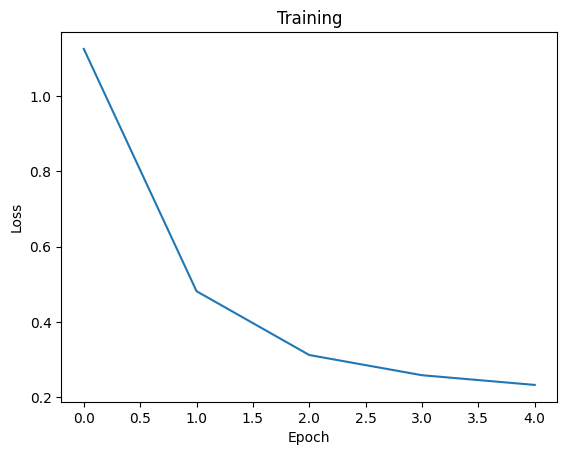

In [ ]:
plt.plot(train_epoch_losses)
plt.title("Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

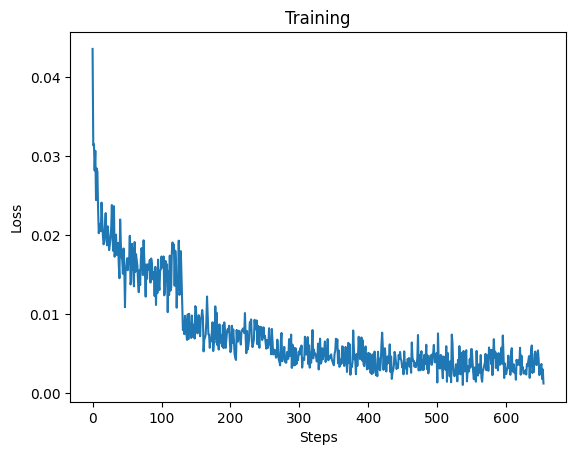

In [ ]:
plt.plot(train_step_losses)
plt.title("Training")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

Now let's check the performance on validation data after finetuning.

In [ ]:
val_loss = 0
image_embeddings = []
text_embeddings = []
for image_batch, input_ids_batch, attention_mask_batch in tqdm(val_ds):
    image_embedding = img_model(image_batch, training=False)
    text_embedding = text_model([input_ids_batch, attention_mask_batch], training=False)

    image_embedding = tf.math.l2_normalize(image_embedding, axis=1)
    text_embedding = tf.math.l2_normalize(text_embedding, axis=1)

    image_embeddings.append(image_embedding.numpy())
    text_embeddings.append(text_embedding.numpy())

    # Compute the loss value for this minibatch.
    loss_value = loss_fn(text_embedding, image_embedding)
    val_loss += float(loss_value)

print(f"Mean Validation Loss: {val_loss / len(val_ds)}")
image_embeddings = np.concatenate(image_embeddings)
text_embeddings = np.concatenate(text_embeddings)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.19it/s]

Mean Validation Loss: 0.8359568986025724


In [ ]:
finetuned_sim = np.matmul(text_embeddings, image_embeddings.T)

for k in range(1, 6):
    print("R@{} : {}".format(k, recall_at_k(finetuned_sim, k)))

R@1 : 0.23734479465138492
R@2 : 0.3328557784145177
R@3 : 0.396370582617001
R@4 : 0.44221585482330467
R@5 : 0.47659980897803245


## Search Using TF Similarity

We can see that there is a significant imrovement in recall metric after only 5 epochs of training.
Now, we can use these modes for retrival based on text query.

In [ ]:
imgs = tf.convert_to_tensor(np.array([get_img_emb(fp) for fp in imgs_list]))

In [ ]:
image_index = tfsim.models.SimilarityModel(img_model.inputs, img_model.outputs)
image_index.create_index(distance='cosine', search='linear', kv_store='memory')

image_index.index(imgs, data=[{"imgs": i, "desc": d} for i,d in zip(imgs, text_list)])

[Indexing 10468 points]
|-Computing embeddings
328/328 [==============================] - 8s 20ms/step
|-Storing data points in key value store


In [ ]:
SEARCH_QUERY = "floral dress"

query_tokens = tokenizer(
    [SEARCH_QUERY],
    padding="max_length",
    return_tensors="tf",
    truncation=True,
)
q_input_ids = tf.convert_to_tensor(np.array(query_tokens["input_ids"]))
q_attention_mask = tf.convert_to_tensor(np.array(query_tokens["attention_mask"]))
query_emb = text_model.predict([q_input_ids, q_attention_mask])


lookups = image_index._index.batch_lookup(predictions=query_emb, k=5, verbose=0)[0]

1/1 [==============================] - 1s 1s/step


In [ ]:
 for i in range(len(lookups)):
    matching_img = lookups[i].data["imgs"]
    matching_desc = lookups[i].data["desc"]
    matching_distance = lookups[i].distance

    print(f"Distance between text query and image: {matching_distance}\n")
    print('\n'.join(textwrap.wrap(matching_desc, width=120)))
    # Channel order is C W H and we need to roll the axis to make it W H C
    plt.imshow(np.rollaxis(matching_img.numpy(), 0, 3));
    plt.show()

    print('\n\n')

## Model Saving

In [ ]:
img_model.save("image_model.h5")
text_model.save("text_model.h5")

However when loading these saved models, the CLIP vision and text models must be provided in custom objects.

In [ ]:
img_model = tf.keras.models.load_model("image_model.h5", custom_objects={"TFCLIPVisionModel": TFCLIPVisionModel})
text_model = tf.keras.models.load_model("text_model.h5", custom_objects={"TFCLIPTextModel": TFCLIPTextModel})